In [1]:
import os, sys, time
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import toml
config = toml.load('../../../../configuration/input_configuration.toml')
%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
relative_path = '../../../../outputs'
pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.2%}".format

In [3]:
conn = create_engine('sqlite:///../../../../inputs/db/'+config['db_name'])
df_obs = pd.read_sql("SELECT * FROM observed_bike_volumes", con=conn)

In [4]:
df = pd.read_csv(os.path.join(relative_path,'network','network_results.csv'))

## Bike Count Scatter
Both directions for all locations, each hour plotted separately

<AxesSubplot:xlabel='observed', ylabel='@bvol'>

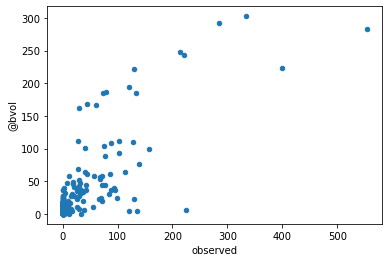

In [5]:
# Get only 2018 data for now
df_obs = df_obs[df_obs['Year'] == 2018]
df_obs = df_obs[['CountID','B_IJ_1', 'B_IJ_2', 'B_IJ_3', 'B_IJ_4', 'B_JI_1', 'B_JI_2', 'B_JI_3', 'B_JI_4']]
df_obs.index = df_obs.CountID
df_obs.drop(['CountID'], axis=1, inplace=True)
df_obs = df_obs.stack()
df_obs = df_obs.reset_index()
tod_map = {'B_IJ_1': '6to7',
           'B_JI_1': '6to7',
          'B_IJ_2': '7to8',
           'B_JI_2': '7to8',
          'B_IJ_3': '16to17',
           'B_JI_3': '16to17',
          'B_IJ_4': '17to18',
           'B_JI_4': '17to18'}
df_obs['tod'] = df_obs['level_1'].map(tod_map)
df_obs.drop('level_1', axis=1, inplace=True)
df_obs.rename(columns={0: 'observed'}, inplace=True)
df_obs['observed'] = df_obs['observed'].astype('float')
df_obs = df_obs.groupby(['CountID','tod']).sum()[['observed']]
df_obs = df_obs.reset_index()

# Group both directions
_df = df[df['@countid'].isin(df_obs['CountID'])]
_df = _df.groupby(['tod','@countid']).sum()[['@bvol']]
_df = _df.reset_index()
_
df_compare = _df[['@countid','tod','@bvol']].merge(df_obs, left_on=['@countid','tod'], right_on=['CountID','tod'])
df_compare[['@bvol','observed']].plot(kind='scatter', x='observed', y='@bvol')

In [6]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_compare['observed'],
                                                               df_compare['@bvol'])
print('r^2: ' + str(r_value))

r^2: 0.8075371645476417


## Total Volume
Both directions on link across all observed time periods
Note that this does not represent daily volumes but the totals for when observed data is available, summed together

<AxesSubplot:xlabel='observed', ylabel='@bvol'>

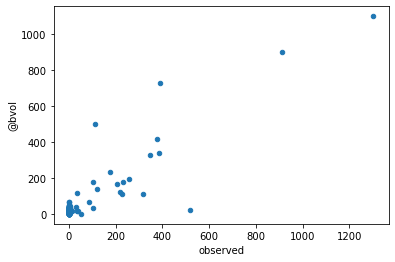

In [7]:
# Combine all count totals available
df_daily = df_compare.groupby('CountID').sum()[['@bvol','observed']]
df_daily[['@bvol','observed']].plot(kind='scatter', x='observed', y='@bvol')

In [8]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_daily['observed'],
                                                               df_daily['@bvol'])
print('r^2: ' + str(r_value))

r^2: 0.8978999114141517


## Top 30 Locations by Observed Volume
Using the total volume as defined directly above

In [9]:
df_daily['diff'] = df_daily['@bvol'] - df_daily['observed']
df_daily['percent_diff'] = df_daily['diff']/df_daily['observed']

# Merge with observed data to get more location context
df_obs = pd.read_sql("SELECT * FROM observed_bike_volumes WHERE year == 2018", con=conn)
df = df_daily.merge(df_obs[['CountID','Jurisdiction','CrossStreets',
                           'Latitude','Longitude','Directions',
                           'PSRCEdgeID']], on='CountID', how='left')

In [10]:
df = df.drop_duplicates()
format_percent = "{:,.2%}".format
_df = df.sort_values('observed',ascending=False).iloc[0:30]
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,CountID,@bvol,observed,diff,percent_diff,Jurisdiction,CrossStreets,Latitude,Longitude,Directions,PSRCEdgeID
13,6001,"1,100","1,303",-203,-15.60%,Seattle,Fremont Bridge,None,None,IJ NB (East sidewalk); JI SB (West sidewalk),"202,159"
20,6009,903,914,-11,-1.19%,Seattle,Westlake PBL at Newton St,None,None,IJ NB; JI SB,"226,819"
19,6008,21,520,-499,-95.96%,Seattle,Elliott Bay Trail at Myrtle Edwards Park,None,None,IJ NB; JI SB,"250,276"
15,6003,731,389,341,87.73%,Seattle,2nd Ave and Madison N of Marion,None,None,IJ SB; JI NB,"182,062"
14,6002,341,388,-47,-12.02%,Seattle,Spokane Street and near 11th Ave SW (W Seattle...,None,None,IJ WB; JI EB,"224,082"
217,6252,416,375,41,10.83%,Medina,SR 520 Trail (East bridge approach),47.637778,122.238861,None,"226,586"
222,6257,328,346,-18,-5.31%,Seattle,UW Transit Center 2 Loops South,47.650394,122.304917,None,NaN
17,6005,109,315,-206,-65.31%,Seattle,Burke Gilman Trail and NE 70th St,None,None,IJ NB; JI SB,"228,459"
21,6011,194,257,-63,-24.54%,Seattle,2nd Ave S of Cedar St,None,None,IJ SB; JI NB,"183,166"
216,6251,178,230,-52,-22.50%,Lake Forest Park,BURKE GILMAN TRAIL,47.753247,122.276939,None,"231,131"


# Top 30 Locations by Modeled Volume

In [11]:
df = df.drop_duplicates()
format_percent = "{:,.2%}".format
_df = df.sort_values('@bvol',ascending=False).iloc[0:30]
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,CountID,@bvol,observed,diff,percent_diff,Jurisdiction,CrossStreets,Latitude,Longitude,Directions,PSRCEdgeID
13,6001,"1,100","1,303",-203,-15.60%,Seattle,Fremont Bridge,None,None,IJ NB (East sidewalk); JI SB (West sidewalk),"202,159"
20,6009,903,914,-11,-1.19%,Seattle,Westlake PBL at Newton St,None,None,IJ NB; JI SB,"226,819"
15,6003,731,389,341,87.73%,Seattle,2nd Ave and Madison N of Marion,None,None,IJ SB; JI NB,"182,062"
16,6004,499,113,386,340.10%,Seattle,Broadway and Union,None,None,IJ NB; JI SB,"182,920"
217,6252,416,375,41,10.83%,Medina,SR 520 Trail (East bridge approach),47.637778,122.238861,None,"226,586"
14,6002,341,388,-47,-12.02%,Seattle,Spokane Street and near 11th Ave SW (W Seattle...,None,None,IJ WB; JI EB,"224,082"
222,6257,328,346,-18,-5.31%,Seattle,UW Transit Center 2 Loops South,47.650394,122.304917,None,NaN
18,6007,232,177,55,31.09%,Seattle,MTS Trail West of I90 Bridge,None,None,IJ EB; JI WB,"242,950"
21,6011,194,257,-63,-24.54%,Seattle,2nd Ave S of Cedar St,None,None,IJ SB; JI NB,"183,166"
216,6251,178,230,-52,-22.50%,Lake Forest Park,BURKE GILMAN TRAIL,47.753247,122.276939,None,"231,131"
